In [ ]:
# --- 환경변수 로드 (.env) ---
# 노트북에서 비밀키/URL/모델을 하드코딩하지 않고, agent/.env 를 읽어오도록 합니다.

from pathlib import Path

try:
    from dotenv import load_dotenv
except Exception as e:
    raise RuntimeError(
        "python-dotenv 가 필요합니다. `pip install python-dotenv` 후 다시 실행하세요."
    ) from e

# Jupyter의 현재 작업 디렉터리는 보통 노트북 위치입니다.
# (레포 루트 = shopping_assistant/) 기준으로 agent/.env 를 우선 로드합니다.
for p in [Path.cwd() / "agent" / ".env", Path.cwd() / ".env"]:
    if p.exists() and p.is_file():
        load_dotenv(p, override=False)

print("dotenv_loaded_candidates=", [str(Path.cwd() / "agent" / ".env"), str(Path.cwd() / ".env")])


In [71]:
import os
import asyncio
import re
import json
from typing import Any, List, Optional
from mcp.client.streamable_http import streamable_http_client
from mcp.client.sse import sse_client
from mcp.client.session import ClientSession

MCP_SNOWFLAKE_BASE_URL = os.getenv(
    "MCP_SNOWFLAKE_URL",
    "https://mcp-snowflake.noa.eland.com/snowflake-mcp",
)
MCP_CORTEX_SEARCH_TOOL = os.getenv("MCP_CORTEX_SEARCH_TOOL", "cortex_search")
MCP_CORTEX_SEARCH_SERVICE_NAME = os.getenv("MCP_CORTEX_SEARCH_SERVICE_NAME", "AICOM_REVIEW")
MCP_CORTEX_DATABASE_NAME = os.getenv("MCP_CORTEX_SEARCH_DATABASE_NAME", "NOA")
MCP_CORTEX_SCHEMA_NAME = os.getenv("MCP_CORTEX_SCHEMA_NAME", "AGENT_BIGDATA")
MCP_CORTEX_SEARCH_COLUMNS = os.getenv("MCP_CORTEX_SEARCH_COLUMNS", ["TOTAL_STYLE_REVIEWS", "STYLE_CODE"])

MCP_CORTEX_ANALYST_URL = os.getenv(
    "MCP_CORTEX_ANALYST_URL",
    "https://mcp-fashion-comp-cortex-agents.noa.eland.com/sse",
)
MCP_CORTEX_ANALYST_TOOL = os.getenv("MCP_CORTEX_ANALYST_TOOL", "aicom_product_analyst")
MCP_CORTEX_ANALYST_QUERY_PARAM = os.getenv("MCP_CORTEX_ANALYST_QUERY_PARAM", "query")


def _unpack_client(client, error_label: str):
    if isinstance(client, tuple):
        if len(client) == 2:
            return client
        if len(client) == 3:
            read, write, _ = client
            return read, write
        raise ValueError(f"Unexpected {error_label} return shape")

    return client.read, client.write


async def _call_mcp_tool(tool_name: str, arguments: dict) -> Any:
    async with streamable_http_client(MCP_SNOWFLAKE_BASE_URL) as client:
        read, write = _unpack_client(client, "streamable_http_client")

        async with ClientSession(read, write) as session:
            await session.initialize()
            return await session.call_tool(tool_name, arguments)


async def _call_mcp_tool_sse(tool_name: str, arguments: dict) -> Any:
    async with sse_client(MCP_CORTEX_ANALYST_URL) as client:
        read, write = _unpack_client(client, "sse_client")

        async with ClientSession(read, write) as session:
            await session.initialize()
            return await session.call_tool(tool_name, arguments)


def _run_async(coro):
    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:
        return asyncio.run(coro)

    try:
        import nest_asyncio

        nest_asyncio.apply()
        return loop.run_until_complete(coro)
    except Exception as exc:
        raise RuntimeError(
            "Running loop detected. Install nest_asyncio to allow nested asyncio."
        ) from exc


def _normalize_tool_result(result: Any) -> Any:
    # 기존 코드(다른 도구 호출과의 호환용): data/results/content만 간단히 추출
    if isinstance(result, list):
        return result
    if isinstance(result, dict):
        if "data" in result:
            return result["data"]
        if "content" in result:
            return result["content"]
        if "results" in result:
            return result["results"]
    if hasattr(result, "content"):
        content = result.content
        if isinstance(content, dict) and "data" in content:
            return content["data"]
        return content
    return result


def _coerce_mcp_payload(result: Any) -> Any:
    """MCP 응답(TextContent/문자열 JSON 등)을 파이썬 dict/list로 최대한 복원."""
    # 1) MCP SDK 객체: .content
    if hasattr(result, "content"):
        try:
            result = result.content
        except Exception:
            pass

    # 2) 리스트로 감싸진 TextContent 1개 케이스
    if isinstance(result, list) and len(result) == 1:
        one = result[0]
        text = None
        if hasattr(one, "text"):
            text = getattr(one, "text", None)
        elif isinstance(one, dict):
            text = one.get("text")
        if isinstance(text, str):
            try:
                return json.loads(text)
            except Exception:
                return result

    # 3) dict 안에 text(JSON string)만 있는 케이스
    if isinstance(result, dict) and isinstance(result.get("text"), str):
        try:
            return json.loads(result["text"])
        except Exception:
            return result

    # 4) 순수 문자열 JSON
    if isinstance(result, str):
        try:
            return json.loads(result)
        except Exception:
            return result

    return result


def _extract_columns_from_sql(sql: Optional[str]) -> List[str]:
    if not sql:
        return []
    match = re.search(r"select\s+(.*?)\s+from", sql, re.IGNORECASE | re.DOTALL)
    if not match:
        return []
    column_segment = match.group(1)
    columns: List[str] = []
    for fragment in column_segment.split(","):
        cleaned = fragment.strip()
        if not cleaned:
            continue
        parts = re.split(r"\s+as\s+", cleaned, flags=re.IGNORECASE)
        if len(parts) == 2:
            column_name = parts[1]
        else:
            column_name = parts[0].split()[-1]
        column_name = column_name.split(".")[-1].strip('"').strip('`')
        columns.append(column_name)
    return columns


def _map_rows_to_dicts(rows: Any, columns: List[str]) -> List[dict]:
    mapped: List[dict] = []
    if isinstance(rows, dict):
        mapped.append(rows)
        return mapped
    if not isinstance(rows, list):
        return mapped
    for row in rows:
        if isinstance(row, dict):
            mapped.append(row)
            continue
        row_list = list(row) if isinstance(row, (list, tuple)) else [row]
        if columns:
            row_mapping = {col: row_list[idx] for idx, col in enumerate(columns) if idx < len(row_list)}
        else:
            row_mapping = {}
        row_mapping.setdefault("_values", row_list)
        mapped.append(row_mapping)
    return mapped


def _extract_style_codes_from_rows(rows: List[dict]) -> List[str]:
    style_codes: List[str] = []
    for row in rows:
        if not isinstance(row, dict):
            continue
        code = (
            row.get("STYLE_CODE")
            or row.get("style_code")
            or row.get("StyleCode")
            or row.get("styleCode")
        )
        if code and isinstance(code, str):
            style_codes.append(code)
    return style_codes


def _summarize_review_text(text: str, max_chars: int = 150) -> str:
    cleaned = " ".join(text.strip().split())
    if not cleaned:
        return ""
    summary_text = cleaned
    llm_client = globals().get("lm")
    if llm_client is not None:
        try:
            prompt = f"다음 리뷰를 1~2문장으로 핵심만 짧게 요약해줘:\n{cleaned}"
            llm_answer = llm_client(prompt)[0]
            summary_text = " ".join(str(llm_answer).split())
        except Exception:
            summary_text = cleaned
    if len(summary_text) <= max_chars:
        return summary_text
    truncated = summary_text[:max_chars]
    if " " in truncated:
        truncated = truncated.rsplit(" ", 1)[0]
    return truncated + "…"


def _process_unstructured_results(payload: Any) -> tuple[List[str], List[str], str]:
    style_codes: List[str] = []
    summaries: List[str] = []
    entries = payload
    if isinstance(payload, dict) and "results" in payload:
        entries = payload["results"]
    if not isinstance(entries, list):
        return style_codes, summaries, ""
    for entry in entries:
        if not isinstance(entry, dict):
            continue
        code = (
            entry.get("STYLE_CODE")
            or entry.get("style_code")
            or entry.get("StyleCode")
            or entry.get("styleCode")
        )
        if code and isinstance(code, str):
            style_codes.append(code)
        review_text = (
            entry.get("TOTAL_STYLE_REVIEWS")
            or entry.get("total_style_reviews")
            or entry.get("Total_Style_Reviews")
            or ""
        )
        summary = _summarize_review_text(str(review_text))
        if summary:
            summaries.append(summary)
    aggregated = "\n".join(summaries[:5])
    return style_codes, summaries, aggregated


def execute_cortex_analyst_sql(constraints: str):
    """
    MCP 서버의 Cortex Analyst 툴을 호출합니다.
    입력: 정형 데이터 필터링 조건 (자연어 쿼리)
    출력: 정형 데이터 리스트 (MCP tool의 data 필드)
    """
    payload = {MCP_CORTEX_ANALYST_QUERY_PARAM: constraints}
    print(
        "   [Tool] MCP Cortex Analyst 호출: "
        f"tool={MCP_CORTEX_ANALYST_TOOL}, param={MCP_CORTEX_ANALYST_QUERY_PARAM}, "
        f"query='{constraints}'"
    )
    raw_result = _run_async(_call_mcp_tool_sse(MCP_CORTEX_ANALYST_TOOL, payload))
    payload_obj = _coerce_mcp_payload(raw_result)

    # payload_obj가 dict라면(sql/result_text/data가 같이 들어옴)
    sql_text = payload_obj.get("sql") if isinstance(payload_obj, dict) else None
    result_text = payload_obj.get("result_text") if isinstance(payload_obj, dict) else None
    data_rows = payload_obj.get("data") if isinstance(payload_obj, dict) else _normalize_tool_result(payload_obj)

    columns = _extract_columns_from_sql(sql_text)
    rows = _map_rows_to_dicts(data_rows, columns)
    style_codes = _extract_style_codes_from_rows(rows)
    return {
        "rows": rows,
        "columns": columns,
        "style_codes": style_codes,
        "sql": sql_text,
        "result_text": result_text,
        "raw_data": payload_obj,
    }


def execute_cortex_search_rag(
    query: str,
    service_name: str = MCP_CORTEX_SEARCH_SERVICE_NAME,
    database_name: str = MCP_CORTEX_DATABASE_NAME,
    schema_name: str = MCP_CORTEX_SCHEMA_NAME,
    columns: Optional[List[str]] = None,
    style_code_filter: Optional[List[str]] = None,
):
    """
    MCP 서버의 Cortex Search 툴을 호출합니다.
    입력: 비정형 검색 키워드 (예: "발이 편하고 통기성 좋은")
    출력: 관련 문서 청크(Chunk) 리스트
    """
    if columns is None:
        columns = MCP_CORTEX_SEARCH_COLUMNS

    if isinstance(columns, str):
        resolved_columns = [col.strip() for col in columns.split(",") if col.strip()]
    elif isinstance(columns, list):
        resolved_columns = columns
    else:
        resolved_columns = [str(columns)]

    payload = {
        "service_name": service_name,
        "database_name": database_name,
        "schema_name": schema_name,
        "query": query,
        "columns": resolved_columns,
        "limit": 10,
    }
    if style_code_filter:
        payload["filter_query"] = {
            "@or": [
                {"@eq": {"STYLE_CODE": code}} for code in style_code_filter if code
            ]
        }
    print(
        "   [Tool] MCP Cortex Search 호출: "
        f"service={service_name}, db={database_name}, schema={schema_name}, "
        f"query='{query}', columns={resolved_columns}"
    )
    raw_result = _run_async(_call_mcp_tool(MCP_CORTEX_SEARCH_TOOL, payload))
    payload_obj = _coerce_mcp_payload(raw_result)

    # payload_obj는 보통 {"results": [...]} 형태
    results_rows = payload_obj.get("results") if isinstance(payload_obj, dict) else _normalize_tool_result(payload_obj)
    style_codes, summaries, review_summary = _process_unstructured_results(payload_obj)
    return {
        "rows": results_rows,
        "style_codes": style_codes,
        "summaries": summaries,
        "review_summary": review_summary,
        "raw_data": payload_obj,
    }


In [72]:
import os
import dspy
from pydantic import BaseModel, Field

# --- DSPy 언어모델 설정 ---
# 주의: AWS 키/리전/모델을 노트북에 하드코딩하지 않습니다.
# 위에서 로드한 `agent/.env` 또는 OS 환경변수에서 가져옵니다.

model = os.getenv(
    "DSPY_MODEL",
    "bedrock/arn:aws:bedrock:ap-northeast-2:960739389910:inference-profile/"
    "apac.anthropic.claude-sonnet-4-20250514-v1:0",
)

lm = dspy.LM(model=model)
dspy.configure(lm=lm)

print("DSPY_MODEL=", model)
print("AWS_REGION=", os.getenv("AWS_REGION"))


In [73]:
## 출력 구조 정의 (Pydantic)
class QueryIntent(BaseModel):
    sql_constraints: str = Field(..., description="가격, 브랜드, 색상, 사이즈 등 DB 컬럼으로 필터링 가능한 조건의 정형 키워드를 한문장으로 표현")
    rag_keywords: str = Field(..., description="분위기, 착용감, 후기, 용도 등 리뷰나 설명에서 찾아야 하는 비정형 키워드를 한문장으로 표현")
    reasoning: str = Field(..., description="왜 이렇게 분리했는지에 대한 짧은 추론")

# 3. DSPy Signature 정의
class IntentSplitter(dspy.Signature):
    """
    사용자의 쇼핑 질의를 분석하여 정형 데이터베이스 검색 조건(SQL)과 
    비정형 텍스트 검색 키워드(RAG)로 분리합니다.
    """
    user_query = dspy.InputField(desc="사용자의 자연어 쇼핑 요청")
    intent: QueryIntent = dspy.OutputField(desc="분리된 검색 의도")

# 4. DSPy Module 정의 (ChainOfThought 활용) 
## 여기서 여러 최적화 방법 추천로직을 디벨럽 해야함
class IntentAnalysisAgent(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought(IntentSplitter)
    
    def forward(self, user_query):
        return self.prog(user_query=user_query)

In [74]:
agent = IntentAnalysisAgent()
result = agent("로엠 따뜻하고 편한 긴팔 추천해줘")

# 가독성 높게 출력
print(f"SQL Constraints: {result.intent.sql_constraints}")
print(f"RAG Keywords: {result.intent.rag_keywords}")
print(f"Reasoning: {result.intent.reasoning}")

SQL Constraints: 로엠 브랜드의 긴팔 상의
RAG Keywords: 따뜻하고 편한 착용감과 소재감
Reasoning: 브랜드명과 상품 카테고리는 DB 필터링으로, 착용감과 소재감은 리뷰 검색으로 분리


In [75]:
from __future__ import annotations

import json
from typing import Any, TypedDict, List, NotRequired

from langgraph.graph import StateGraph, END


# --- State 정의 ---
# API 개발을 염두에 두고, "LLM 응답 텍스트"와 "상품 메타(rows)"를 분리해서 보관합니다.
class ShoppingState(TypedDict):
    # 입력
    user_query: str
    structured_query: NotRequired[str]

    # Intent
    sql_constraints: str
    rag_keywords: str

    # Structured (Cortex Analyst)
    structured_columns: NotRequired[List[str]]
    structured_sql: NotRequired[str]
    structured_result_text: NotRequired[str]
    structured_data: List[dict]
    structured_style_codes: NotRequired[List[str]]

    # Unstructured (Cortex Search)
    cortex_service_name: str
    cortex_database_name: str
    cortex_schema_name: str
    cortex_columns: List[str]
    unstructured_data: List[dict]
    unstructured_style_codes: NotRequired[List[str]]
    unstructured_reviews_summary: NotRequired[str]

    # Fusion output ("결정"만: 텍스트 금지)
    fusion_decision: NotRequired[dict]
    recommended_style_codes: NotRequired[List[str]]
    recommended_products: NotRequired[List[dict]]

    # Composer output ("표현"만)
    llm_text: NotRequired[str]

    # 최종 응답(기존 호환용: llm_text를 그대로 넣음)
    final_response: str

    # API용 최종 payload (LLM 텍스트 + 상품 메타 분리)
    api_response: NotRequired[dict]


# --- Nodes (각 단계의 로직) ---

def intent_analysis_node(state: ShoppingState):
    print("\n--- [Node] Intent Analysis (DSPy) ---")
    dspy_agent = IntentAnalysisAgent()
    intent_query = state.get("structured_query", state["user_query"])
    prediction = dspy_agent(intent_query)

    intent = prediction.intent
    print(f"Structured: {intent.sql_constraints}")
    print(f"Unstructured: {intent.rag_keywords}")

    return {
        "sql_constraints": intent.sql_constraints,
        "rag_keywords": intent.rag_keywords,
    }


def structured_query_node(state: ShoppingState):
    print("\n--- [Node] Structured Query Agent (Cortex Analyst) ---")
    constraints = state.get("sql_constraints")
    if not constraints:
        raise ValueError("sql_constraints is required for the structured query node")

    analyst_result = execute_cortex_analyst_sql(constraints)

    # execute_cortex_analyst_sql은 rows/columns/sql/result_text를 분리해 반환합니다.
    return {
        "structured_data": analyst_result.get("rows", []),
        "structured_columns": analyst_result.get("columns", []),
        "structured_style_codes": analyst_result.get("style_codes", []),
        "structured_sql": analyst_result.get("sql"),
        "structured_result_text": analyst_result.get("result_text"),
    }


def unstructured_query_node(state: ShoppingState):
    print("\n--- [Node] Unstructured Query Agent (Cortex Search) ---")
    keywords = state["rag_keywords"]

    service_name = state.get("cortex_service_name", MCP_CORTEX_SEARCH_SERVICE_NAME)
    database_name = state.get("cortex_database_name", MCP_CORTEX_DATABASE_NAME)
    schema_name = state.get("cortex_schema_name", MCP_CORTEX_SCHEMA_NAME)
    columns = state.get("cortex_columns", MCP_CORTEX_SEARCH_COLUMNS)

    structured_codes = state.get("structured_style_codes", [])

    results = execute_cortex_search_rag(
        keywords,
        service_name=service_name,
        database_name=database_name,
        schema_name=schema_name,
        columns=columns,
        style_code_filter=structured_codes,
    )

    return {
        "unstructured_data": results.get("rows", []),
        "unstructured_style_codes": results.get("style_codes", []),
        "unstructured_reviews_summary": results.get("review_summary", ""),
    }


def _safe_json_loads(text: str) -> Any:
    try:
        return json.loads(text)
    except Exception:
        return None


def _pick_products_by_style_codes(products: List[dict], style_codes: List[str]) -> List[dict]:
    """추천 style_code의 '순서'를 보존해서 상품을 뽑습니다."""
    if not style_codes:
        return []

    # style_code -> product 매핑 (첫 번째 매칭만 사용)
    by_code: dict[str, dict] = {}
    for p in products:
        if not isinstance(p, dict):
            continue
        code = p.get("style_code") or p.get("STYLE_CODE")
        if isinstance(code, str) and code and code not in by_code:
            by_code[code] = p

    picked: List[dict] = []
    for code in style_codes:
        p = by_code.get(code)
        if p:
            picked.append(p)
    return picked


def result_fusion_node(state: ShoppingState):
    print("\n--- [Node] Result Fusion & Reasoning ---")

    # 이 노드는 "결정"만 합니다: 추천할 style_code / 근거 / 주의사항 등을 구조화해서 반환.
    # (사용자에게 보여줄 문장 생성은 composer에서만 수행)
    products = state.get("structured_data", [])
    query = state["user_query"]
    reviews_summary = state.get("unstructured_reviews_summary", "")
    review_style_codes = state.get("unstructured_style_codes", [])

    # LLM에게 구조화된 JSON만 출력하도록 요청
    prompt = f"""
너는 쇼핑 추천 시스템의 '결정(Decision)' 모듈이다.

사용자 질문: {query}

[상품 후보 목록(정형 데이터, JSON list)]:
{products}

[리뷰 요약(비정형)]:
{reviews_summary or '리뷰 요약 없음'}

[리뷰에서 언급된 style_code 후보]:
{review_style_codes}

규칙:
- 반드시 'JSON'만 출력해라. (설명 문장/마크다운/코드펜스 금지)
- 아래 스키마를 지켜라.

스키마:
{{
  "recommended_style_codes": ["..."] ,
  "reason_bullets": ["..."] ,
  "caveats": ["..."]
}}

추천은 30개 이내로 하고, style_code는 상품 후보 목록에 실제 존재하는 코드만 넣어라.
""".strip()

    raw = lm(prompt)[0]
    decision = _safe_json_loads(raw)

    # 파싱 실패/형식 불량이면 휴리스틱 fallback
    if not isinstance(decision, dict):
        decision = {}

    rec_codes = decision.get("recommended_style_codes")
    if not isinstance(rec_codes, list) or not rec_codes:
        # 1) 리뷰 style_code와 상품 style_code 교집합 우선
        product_codes = [p.get("style_code") for p in products if isinstance(p, dict) and p.get("style_code")]
        inter = [c for c in review_style_codes if c in set(product_codes)]
        rec_codes = inter[:30] if inter else product_codes[:30]

    rec_codes = [c for c in rec_codes if isinstance(c, str) and c]
    rec_products = _pick_products_by_style_codes(products, rec_codes)

    return {
        "fusion_decision": {
            "recommended_style_codes": rec_codes,
            "reason_bullets": decision.get("reason_bullets", []) if isinstance(decision.get("reason_bullets", []), list) else [],
            "caveats": decision.get("caveats", []) if isinstance(decision.get("caveats", []), list) else [],
        },
        "recommended_style_codes": rec_codes,
        "recommended_products": rec_products,
    }


def _fallback_recommend_products(
    products: List[dict],
    query: str,
    k: int = 30,
) -> List[dict]:
    """범용 fallback 추천.

    LLM(fusion)이 비었거나 파싱 실패한 경우를 대비해,
    사용자 질의(query)와 상품 메타 텍스트의 매칭 점수로 상위 k개를 뽑습니다.
    """

    q = (query or "").strip().lower()
    q_tokens = [t for t in q.replace(",", " ").split() if t]

    def norm_text(p: dict) -> str:
        return " ".join(
            [
                str(p.get("brand", "")),
                str(p.get("product_name", "")),
                str(p.get("style_tags", "")),
                str(p.get("material", "")),
                str(p.get("subcategory", "")),
                str(p.get("category", "")),
                str(p.get("color", "")),
            ]
        ).lower()

    def contains(text: str, token: str) -> bool:
        return token and token in text

    scored: List[tuple[int, int, dict]] = []
    for idx, p in enumerate(products):
        if not isinstance(p, dict):
            continue

        t = norm_text(p)
        score = 0

        # 기본: 토큰 매칭 (간단하지만 일반적으로 잘 먹힘)
        for tok in q_tokens:
            if contains(t, tok):
                score += 5

        # 보조: 자주 쓰는 구매 의도 키워드 가중치
        if "기모" in q and "기모" in t:
            score += 10
        if ("긴팔" in q or "긴소매" in q or "롱슬리브" in q) and (
            ("긴팔" in t) or ("긴소매" in t) or ("롱슬리브" in t)
        ):
            score += 10
        if "편" in q and ("편" in t or "밴딩" in t or "스판" in t):
            score += 3

        # 카테고리 힌트: query에 상의/아우터/바지 등 단어가 있으면 해당 카테고리 약간 우대
        if "상의" in q and str(p.get("category", "")) == "상의":
            score += 6
        if "아우터" in q and str(p.get("category", "")) == "아우터":
            score += 6
        if "바지" in q and str(p.get("category", "")) == "바지":
            score += 6

        scored.append((score, idx, p))

    # 점수 동일하면 원본 순서 유지
    scored.sort(key=lambda x: (-x[0], x[1]))

    picked = [p for _, _, p in scored[:k]]

    # 혹시라도 비면(데이터 이상) 그냥 앞에서 k개
    if not picked:
        picked = [p for p in products if isinstance(p, dict)][:k]

    return picked


def response_composer_node(state: ShoppingState):
    print("\n--- [Node] Response Composer ---")

    # 이 노드는 "표현"만 합니다: fusion_decision + 상품 메타를 받아 사용자용 텍스트를 생성.
    query = state["user_query"]
    products = state.get("structured_data", [])

    rec_products = state.get("recommended_products", [])
    if not rec_products and products:
        # Fusion 추천이 비면 범용 fallback으로 최대 30개 강제 추천
        rec_products = _fallback_recommend_products(products, query=query, k=30)

    decision = state.get("fusion_decision", {})

    # --- 카테고리별 그룹핑 (패션 의류 전용) ---
    # category 값이 없으면 subcategory, 그것도 없으면 '기타'로 묶습니다.
    grouped: dict[str, List[dict]] = {}
    category_order: List[str] = []

    for p in rec_products:
        if not isinstance(p, dict):
            continue
        cat = p.get("category") or p.get("subcategory") or "기타"
        cat = str(cat)
        if cat not in grouped:
            grouped[cat] = []
            category_order.append(cat)
        grouped[cat].append(p)

    grouped_recommended_products = {cat: grouped[cat] for cat in category_order}

    # composer 프롬프트 (문장 생성)
    prompt = f"""
사용자 질문: {query}

아래는 추천 결정 결과다(구조화):
{decision}

아래는 추천 상품(카테고리별 그룹)이다:
{grouped_recommended_products}

요청:
- 한국어로, 사용자 질문에 맞는 '패션 의류 쇼핑 추천' 답변을 작성해라.
- 반드시 카테고리별 섹션(예: '상의', '아우터', '바지' 등)으로 나눠서 작성해라.
- 각 섹션에서 상위 추천부터 보여줘라.
- 추천은 총 최대 30개까지 가능하나, 너무 길어지면 카테고리별로 '상세 3~5개 + 나머지 간단 나열' 방식으로 요약해라.
- 각 상품의 상세 표기는 가능한 한 (상품명, 가격, 색상, 사이즈, 소재/특징 1줄, 링크(url))을 포함해라.
- 사용자의 의도가 불명확하면, 마지막에 선택 질문 1~2개(예: 핏/예산/사용상황)를 짧게 추가해라.
""".strip()

    llm_text = lm(prompt)[0]

    # 추천 코드도 composer 기준(=fallback 포함)으로 확정
    derived_rec_codes: List[str] = []
    for p in rec_products:
        if not isinstance(p, dict):
            continue
        code = p.get("style_code") or p.get("STYLE_CODE")
        if isinstance(code, str) and code:
            derived_rec_codes.append(code)

    # products(rows)를 "추천 랭킹 순"으로 정렬: recommended_products 먼저, 나머지는 뒤에 유지
    rec_code_set = set(derived_rec_codes)
    rest_products: List[dict] = []
    for p in products:
        if not isinstance(p, dict):
            continue
        code = p.get("style_code") or p.get("STYLE_CODE")
        if isinstance(code, str) and code in rec_code_set:
            continue
        rest_products.append(p)

    ranked_products = (rec_products or []) + rest_products

    api_response = {
        "llm_text": llm_text,
        # API 응답에서는 recommended_products만 제공 (전체 products는 제외)
        "recommended_products": rec_products,
        "grouped_recommended_products": grouped_recommended_products,
        "recommended_style_codes": derived_rec_codes,
        "structured": {
            "sql": state.get("structured_sql"),
            "columns": state.get("structured_columns", []),
            "result_text": state.get("structured_result_text"),
        },
        "unstructured": {
            "review_summary": state.get("unstructured_reviews_summary", ""),
            "review_style_codes": state.get("unstructured_style_codes", []),
        },
    }

    # final_response는 기존 코드 호환을 위해 llm_text 그대로 유지
    return {
        "llm_text": llm_text,
        "final_response": llm_text,
        "api_response": api_response,
    }


In [76]:
# 그래프 초기화
workflow = StateGraph(ShoppingState)

# 노드 추가
workflow.add_node("intent_agent", intent_analysis_node)
workflow.add_node("structured_agent", structured_query_node)     # Snowflake Cortex Analyst
workflow.add_node("unstructured_agent", unstructured_query_node) # Snowflake Cortex Search
workflow.add_node("fusion_agent", result_fusion_node)
workflow.add_node("composer", response_composer_node)

# 엣지(Edge) 연결
# 1. 시작 -> 의도 분석
workflow.set_entry_point("intent_agent")

# 2. 의도 분석 -> 정형 에이전트 -> 비정형 에이전트 (직렬 실행)
# 비정형 검색에서 structured_agent의 style_code 필터를 쓰기 위해 순차 실행합니다.
workflow.add_edge("intent_agent", "structured_agent")
workflow.add_edge("structured_agent", "unstructured_agent")

# 3. 비정형 에이전트 완료 -> 결과 융합
workflow.add_edge("unstructured_agent", "fusion_agent")

# 4. 결과 융합 -> 응답 생성 -> 종료
workflow.add_edge("fusion_agent", "composer")
workflow.add_edge("composer", END)

# 컴파일 (실행 가능한 앱 생성)
app = workflow.compile()

그래프 구조:


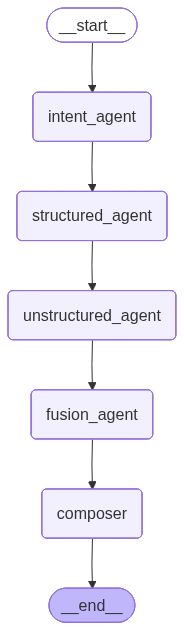

In [77]:
from IPython.display import Image, display

print("그래프 구조:")
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # png 변환 실패 시 텍스트로 출력
    print(app.get_graph().draw_mermaid())

In [78]:
user_query = "로엠 따뜻하고 편한 기모 긴팔 추천해줘"

print(f"User Query: {user_query}\n")
print("--- LangGraph Execution Trace ---")

# NOTE:
# stream + invoke를 연달아 호출하면 MCP 도구가 2번 호출되어 결과가 달라 보일 수 있습니다.
# 기본은 1회 실행(invoke)만 하고, trace가 필요할 때만 RUN_TRACE=True로 켜세요.
RUN_TRACE = False

if RUN_TRACE:
    for s in app.stream({"user_query": user_query}):
        for key, value in s.items():
            print(f"[{key}]")
            for sub_key, sub_value in value.items():
                if isinstance(sub_value, list):
                    print(f"  {sub_key}: <list len={len(sub_value)}>")
                elif isinstance(sub_value, dict):
                    print(f"  {sub_key}: <dict keys={list(sub_value.keys())}>")
                else:
                    print(f"  {sub_key}: {sub_value}")
        print("----------------------------------")

# API 형태로 최종 결과 확인
# - recommended_products가 비어있으면, MCP 결과가 간헐적으로 비는 케이스를 대비해 자동 재시도합니다.
MAX_RETRIES = 3
final_state = None

for attempt in range(1, MAX_RETRIES + 1):
    final_state = app.invoke({"user_query": user_query})
    api_response = final_state.get("api_response", {}) if isinstance(final_state, dict) else {}
    rec = api_response.get("recommended_products", []) if isinstance(api_response, dict) else []

    print(f"\n--- [Invoke Attempt {attempt}/{MAX_RETRIES}] ---")
    print(f"recommended_products: {len(rec)}")

    if rec:
        break

print("\n--- [LLM Text] ---")
print((final_state or {}).get("llm_text") or (final_state or {}).get("final_response"))

print("\n--- [Recommended Products] ---")
api_response = (final_state or {}).get("api_response", {})
rec = api_response.get("recommended_products", []) if isinstance(api_response, dict) else []
print(f"recommended_products count: {len(rec)}")
print(rec)


User Query: 로엠 따뜻하고 편한 기모 긴팔 추천해줘

--- LangGraph Execution Trace ---

--- [Node] Intent Analysis (DSPy) ---
Structured: 브랜드가 로엠이고 기모 소재의 긴팔 상품
Unstructured: 따뜻하고 편안한 착용감과 포근한 기모 소재의 질감

--- [Node] Structured Query Agent (Cortex Analyst) ---
   [Tool] MCP Cortex Analyst 호출: tool=aicom_product_analyst, param=query, query='브랜드가 로엠이고 기모 소재의 긴팔 상품'

--- [Node] Unstructured Query Agent (Cortex Search) ---
   [Tool] MCP Cortex Search 호출: service=AICOM_REVIEW, db=NOA, schema=AGENT_BIGDATA, query='따뜻하고 편안한 착용감과 포근한 기모 소재의 질감', columns=['TOTAL_STYLE_REVIEWS', 'STYLE_CODE']

--- [Node] Result Fusion & Reasoning ---

--- [Node] Response Composer ---

--- [Invoke Attempt 1/3] ---
recommended_products: 19

--- [LLM Text] ---
# 🧥 로엠 따뜻하고 편한 긴팔 추천

기모 전용 제품은 현재 재고가 부족하지만, 따뜻하고 편안한 대체 보온 소재로 25FW 신상품을 중심으로 추천드릴게요!

## 👕 상의 (니트/스웨터 & 긴팔 티셔츠)

### ✨ 특별 추천 상품

**1. 올데이니트 울100 라운드넥 스웨터 (RMKAF4VR02)**
- 가격: 29,950원
- 색상: 라이트그레이, 블랙, 엠브라운
- 사이즈: S(090), M(095), L(100)
- 특징: 울 100% 소재로 뛰어난 보온성, 겨울철 필수 아이템
- [